## 환경 설정 및 라이브러리 불러오기 (한글 폰트 체크!!)

In [ ]:
# 구글 드라이브 연결 및 경로 설정 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data processing
# ==============================================================================
import os
import numpy as np
import pandas as pd
!pip install datatable -q 
import datatable as dt
import math

# Modelling and Forecasting
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

!pip install catboost -q
from catboost import CatBoostRegressor

!pip install tslearn -q 
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

!pip install optuna -q
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler

from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

     |████████████████████████████████| 96.9 MB 82 kB/s 


     |████████████████████████████████| 76.6 MB 73 kB/s 
     |████████████████████████████████| 793 kB 8.9 MB/s 
     |████████████████████████████████| 308 kB 7.3 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 209 kB 68.6 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 112 kB 78.7 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 147 kB 53.7 MB/s 


The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 155673 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


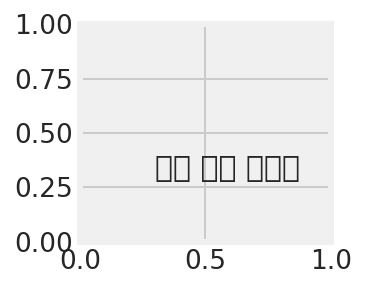

In [ ]:
# Plots
# ==============================================================================
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid',font_scale=1.2)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

## * 이 셀이 제대로 작동하지 않고 길게 warning 메시지가 나올 경우, 상단의 메뉴에서 <런타임>-<런타임 다시 시작>을 클릭한 뒤 처음부터 코드를 실행하세요 
# 그래프 한글 폰트 설정

import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'retina'

#폰트 설치
!apt -qq -y install fonts-nanum

#기본 폰트로 지정
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

#폰트 선명하게 보이게 하기 위해
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Test
plt.figure(figsize=(2,2))
plt.text(0.3, 0.3, '한글 폰트 테스트', size=15)
plt.show() 

In [ ]:
path = "/content/drive/MyDrive/날씨 빅콘/data"
os.chdir(path) 

## 지수데이터 추가 

In [ ]:
################################ 데이터 업데이트하기 ################################
train = dt.fread(path+'/전처리데이터/train_test/ver_0729/train_0729.csv').to_pandas()
test = dt.fread(path+'/전처리데이터/train_test/ver_0729/test_0729.csv').to_pandas()
################################################################################ 

In [ ]:
train_index = dt.fread(path+'/전처리데이터/train_pop_index.csv').to_pandas()
test_index = dt.fread(path+'/전처리데이터/test_pop_index.csv').to_pandas()

In [ ]:
train.columns.drop(train.columns[train.columns.str.contains('_lag|_shift')]) 

Index(['yyyymmdd', 'area', 'sex', 'frequency', 'dd_mes', 'sum_dpth_fhsc',
       'dd_mefs', 'ssrate', 'ss_dur', 'sum_ss_hr', 'min_tg', 'avg_pa',
       'max_pa', 'min_pa', 'avg_pv', 'max_pv', 'min_pv', 'avg_rhm', 'min_rhm',
       'sum_rn', 'sum_rn_dur', 'mi10_max_rn', 'hr1_max_rn', 'hr6_max_rn',
       'n9_9_rn', 'avg_ta', 'max_ta', 'min_ta', 'avg_ws', 'max_ws',
       'max_ins_ws', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'rainfall_24',
       'snow_24', 'temp_24', 'temp_48', 'humid_24', 'humid_48', 'max_temp_24',
       'min_temp_24', 'wind_24', 'wind_48', 'pop_over50', 'num_back', 'year',
       '심정지', '뇌졸중_진단', '심장병_진단', '고혈압_진단', '이상지질혈증_진단', '뇌졸중_약물치료',
       '심장병_약물치료', '고혈압_약물치료', '이상지질혈증_약물치료', '뇌졸중_가족력', '심장병_가족력', '고혈압_가족력',
       'day1', 'smoking', 'day_mean_smoke_over1'],
      dtype='object')

In [ ]:
# 지수 데이터만 저장 
train_index = pd.concat( [train_index.iloc[:, :3], train_index.iloc[:, 42:]], axis=1)

# 지수 변수들 이름 단순화
train_index.columns = ['yyyymmdd', 'area', 'sex',  
                       'A03_max', 'A03_min', 'A03_mean', 'A03_range', 'A03_iqr', 
                       'A03_max_24', 'A03_min_24', 'A03_mean_24', 'A03_range_24', 'A03_iqr_24',
                       'A03_max_48', 'A03_min_48', 'A03_mean_48', 'A03_range_48', 'A03_iqr_48',
                       'A07_max', 'A07_min', 'A07_mean', 'A07_range', 'A07_iqr', 
                       'D02_max', 'D02_min', 'D02_median', 'D02_range', 
                       'D02_max_24', 'D02_min_24', 'D02_median_24', 'D02_range_24', 
                       'D02_max_48', 'D02_min_48', 'D02_median_48', 'D02_range_48'] 

# 기존 train과 지수 변수들 병합 
train = pd.merge(train, train_index, how='left', on=['yyyymmdd',	'area',	'sex'])
train.head()

,yyyymmdd,area,sex,frequency,dd_mes,sum_dpth_fhsc,dd_mefs,ssrate,ss_dur,sum_ss_hr,...,D02_median,D02_range,D02_max_24,D02_min_24,D02_median_24,D02_range_24,D02_max_48,D02_min_48,D02_median_48,D02_range_48
0,2012-01-01,강원,1,3.0,10.136053,2.155943,1.303480,35.856285,9.632506,3.444997,...,0.032722,0.0,0.032722,0.032722,0.032722,0.0,0.032722,0.032722,0.032722,0.0
1,2012-01-01,강원,2,3.0,10.136053,2.155943,1.303480,35.856285,9.632506,3.444997,...,0.032722,0.0,0.032722,0.032722,0.032722,0.0,0.032722,0.032722,0.032722,0.0
2,2012-01-01,경기,1,4.0,1.029764,0.085438,0.096118,25.748326,9.669065,2.485800,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,2012-01-01,경기,2,5.0,1.029764,0.085438,0.096118,25.748326,9.669065,2.485800,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,2012-01-01,경남,1,2.0,0.865082,0.293056,0.533394,29.514334,9.814313,2.896959,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [ ]:
# 지수 데이터만 저장 
test_index = pd.concat( [test_index.iloc[:, :3], test_index.iloc[:, 41:]], axis=1)
# 지수 변수들 이름 단순화
test_index.columns = ['yyyymmdd', 'area', 'sex',  
                       'A03_max', 'A03_min', 'A03_mean', 'A03_range', 'A03_iqr', 
                       'A03_max_24', 'A03_min_24', 'A03_mean_24', 'A03_range_24', 'A03_iqr_24',
                       'A03_max_48', 'A03_min_48', 'A03_mean_48', 'A03_range_48', 'A03_iqr_48',
                       'A07_max', 'A07_min', 'A07_mean', 'A07_range', 'A07_iqr', 
                       'D02_max', 'D02_min', 'D02_median', 'D02_range', 
                       'D02_max_24', 'D02_min_24', 'D02_median_24', 'D02_range_24', 
                       'D02_max_48', 'D02_min_48', 'D02_median_48', 'D02_range_48'] 

# 기존 train과 지수 변수들 병합 
test = pd.merge(test, test_index, how='left', on=['yyyymmdd',	'area',	'sex'])
test.head()

,yyyymmdd,area,sex,dd_mes,sum_dpth_fhsc,dd_mefs,ssrate,ss_dur,sum_ss_hr,min_tg,...,D02_median,D02_range,D02_max_24,D02_min_24,D02_median_24,D02_range_24,D02_max_48,D02_min_48,D02_median_48,D02_range_48
0,2016-01-01,강원,1,25.262803,8.088057,6.832984,41.929419,9.633102,4.029989,-8.917460,...,1.418733,0.0,1.078984,1.048858,1.063921,0.030126,1.082399,1.006161,1.044280,0.076238
1,2016-01-01,강원,2,25.262803,8.088057,6.832984,41.929419,9.633102,4.029989,-8.917460,...,1.418733,0.0,1.078984,1.048858,1.063921,0.030126,1.082399,1.006161,1.044280,0.076238
2,2016-01-01,경기,1,3.140683,0.247502,0.263841,19.758979,9.668681,1.907674,-6.721469,...,1.764691,0.0,1.001175,1.000309,1.000742,0.000866,1.030430,1.001846,1.016138,0.028585
3,2016-01-01,경기,2,3.140683,0.247502,0.263841,19.758979,9.668681,1.907674,-6.721469,...,1.764691,0.0,1.001175,1.000309,1.000742,0.000866,1.030430,1.001846,1.016138,0.028585
4,2016-01-01,경남,1,0.415067,0.216473,0.155119,86.066663,9.814577,8.444625,-6.450657,...,1.977000,0.0,2.054754,2.008012,2.031383,0.046743,1.833755,1.600635,1.717195,0.233121


In [ ]:
print(train['D02_range'].value_counts())

# D02_range 변수는 값이 모두 0인 constant이므로 제거 
train = train.drop('D02_range', axis=1)
test = test.drop('D02_range', axis=1) 

0.0    49674
Name: D02_range, dtype: int64


In [ ]:
print(train.shape)

(49674, 201)


In [ ]:
print(test.shape)

(12444, 200)


## 요일 / 계절 변수 생성

In [ ]:
full_data = [train, test] 

In [ ]:
for dataset in full_data:
  dataset.set_index('yyyymmdd', inplace=True)

In [ ]:
# 새로운 변수 생성 
## 1) day: 요일 변수, cyclical encoding
day_in_week = 7

for dataset in full_data:
  dataset['weekday']= dataset.index.weekday + 1
  dataset['weekday_sin'] = np.sin(2*np.pi*dataset['weekday']/day_in_week)
  dataset['weekday_cos'] = np.cos(2*np.pi*dataset['weekday']/day_in_week)
  dataset.drop(['weekday'], axis=1, inplace=True)

## 2) season: 계절 변수, cyclical encoding 
scale_mapper = {"spring":1, "summer":2, "fall":3, "winter":4}

for dataset in full_data:
  dataset['season'] = dataset.index.month%12 // 3 + 1
  dataset["season"] = dataset["season"].replace(scale_mapper)

  dataset['season_sin'] = np.sin(2*np.pi*dataset['season']/day_in_week)
  dataset['season_cos'] = np.cos(2*np.pi*dataset['season']/day_in_week)
  dataset.drop(['season'], axis=1, inplace=True) 

In [ ]:
full_data[0].head(3)

,area,sex,frequency,dd_mes,sum_dpth_fhsc,dd_mefs,ssrate,ss_dur,sum_ss_hr,min_tg,...,D02_median_24,D02_range_24,D02_max_48,D02_min_48,D02_median_48,D02_range_48,weekday_sin,weekday_cos,season_sin,season_cos
yyyymmdd,,,,,,,,,,,,,,,,,,,,,
2012-01-01,강원,1,3.0,10.136053,2.155943,1.303480,35.856285,9.632506,3.444997,-9.869523,...,0.032722,0.0,0.032722,0.032722,0.032722,0.0,-2.449294e-16,1.0,0.781831,0.62349
2012-01-01,강원,2,3.0,10.136053,2.155943,1.303480,35.856285,9.632506,3.444997,-9.869523,...,0.032722,0.0,0.032722,0.032722,0.032722,0.0,-2.449294e-16,1.0,0.781831,0.62349
2012-01-01,경기,1,4.0,1.029764,0.085438,0.096118,25.748326,9.669065,2.485800,-9.789545,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,-2.449294e-16,1.0,0.781831,0.62349


In [ ]:
train.to_csv(path+'/전처리데이터/train_test/ver_0801/train_0801.csv')
test.to_csv(path+'/전처리데이터/train_test/ver_0801/test_0801.csv')